In [ ]:
import numpy as np
import cv2
from PIL import Image 
from google.colab.patches import cv2_imshow

# Parameters
blur = 21
canny_low = 30
canny_high = 200
inWidth = 300
inHeight = 300

inputImageName = "./drive/MyDrive/PoseProject/lbj.png"
refImageName = "./drive/MyDrive/PoseProject/cr.png"
# inputImageName = "cr3.png"
# refImageName = "lbj.png"

def getContourPoints(imageName):
  inputImage = cv2.imread(imageName)
  inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))
  # Convert image to grayscale        
  image_gray = cv2.cvtColor(inputImageResize, cv2.COLOR_BGR2GRAY)
  # Apply Canny Edge Dection
  edges = cv2.Canny(image_gray, canny_low, canny_high)
  edges = cv2.dilate(edges, None)
  edges = cv2.erode(edges, None)
  # get the contours and their areas
  inputContours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  inputMaxContour = inputContours[0]
  for contour in inputContours:
    if cv2.contourArea(contour) > cv2.contourArea(inputMaxContour):
      inputMaxContour = contour

  inputContourPoints = inputMaxContour[:, 0, :]
  for point in inputContourPoints:
    inputImageResize[point[1], point[0], 0] = 0
    inputImageResize[point[1], point[0], 1] = 255
    inputImageResize[point[1], point[0], 2] = 0

  cv2_imshow(inputImageResize) 

  return inputContourPoints

inputContourPoints = getContourPoints(inputImageName)
refContourPoints = getContourPoints(refImageName)

In [ ]:
###detect pose
#0: head
#1: chest
#2: left shoulder
#3: left elbow
#4: left hand
#5: right shoulder
#6: right elbow
#7: right hand
#8: left waist
#9: left knee
#10: left foot
#11: right waist
#12: right knee
#13: right foot

protoFile = "./drive/MyDrive/PoseProject/pose_deploy_linevec.prototxt"
weightsFile = "./drive/MyDrive/PoseProject/pose_iter_440000.caffemodel"

nPoints = 14
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]

threshold = 0.01
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

def getPosePoints(imageName):
  inputImage = cv2.imread(imageName)
  inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))
  inpBlob = cv2.dnn.blobFromImage(inputImageResize, 1.0 / 255, (inWidth, inHeight),
                            (0, 0, 0), swapRB=False, crop=False)
  net.setInput(inpBlob)
  output = net.forward()

  H = output.shape[2]
  W = output.shape[3]

  points = []
  shouldSave = True
  for i in range(nPoints):
      # confidence map of corresponding body's part.
      probMap = output[0, i, :, :]

      # Find global maxima of the probMap.
      minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

      #print("%d and %d" % (point[1], point[0]))
      if prob > threshold : 
          hh = int(point[1] * inHeight / H)
          ww = int(point[0] * inWidth / W)
          points.append((ww, hh))
          #print(hh, ww)
          inputImageResize[hh, ww, :] = (0, 255, 0)
          inputImageResize[hh+1, ww, :] = (0, 255, 0)
          inputImageResize[hh, ww+1, :] = (0, 255, 0)
          inputImageResize[hh+1, ww+1, :] = (0, 255, 0)

      else :
          print("Bad")
          shouldSave = False
          continue

  cv2_imshow(inputImageResize)

  lines = []
  for pair in POSE_PAIRS:
    indexStart = pair[0]
    indexEnd = pair[1]
    lines.append((points[indexStart], points[indexEnd]))

  return lines

inputPoseLines = getPosePoints(inputImageName)
refPoseLines = getPosePoints(refImageName)


In [ ]:
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]

pointsLBJ = [(153,49),
               (153,83),
               (131,79),
               (106,72),
               (69,27),
               (168,81),
               (196,79),
               (233,40),
               (138,150),
               (137,216),
               (124,280),
               (159,151),
               (161,216),
               (152,280)]


inputImage = cv2.imread("./drive/MyDrive/PoseProject/lbj.png")
inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))

for point in pointsLBJ:
  ww, hh = point
  inputImageResize[hh, ww, :] = (0, 255, 0)
  inputImageResize[hh+1, ww, :] = (0, 255, 0)
  inputImageResize[hh, ww+1, :] = (0, 255, 0)
  inputImageResize[hh+1, ww+1, :] = (0, 255, 0)

cv2_imshow(inputImageResize)

pointsCR =    [(142,13),
               (148,68),
               (112,83),
               (108,120),
               (53,170),
               (200,79),
               (223,119),
               (257,170),
               (123,154),
               (97,216),
               (51,280),
               (175,153),
               (212,217),
               (277,280)]

refImage = cv2.imread("./drive/MyDrive/PoseProject/cr.png")
refImageResize = cv2.resize(refImage, (inWidth, inHeight))

for point in pointsCR:
  ww, hh = point
  refImageResize[hh, ww, :] = (0, 255, 0)
  refImageResize[hh+1, ww, :] = (0, 255, 0)
  refImageResize[hh, ww+1, :] = (0, 255, 0)
  refImageResize[hh+1, ww+1, :] = (0, 255, 0)

cv2_imshow(refImageResize)

inputPoseLines = []
for pair in POSE_PAIRS:
  indexStart = pair[0]
  indexEnd = pair[1]
  inputPoseLines.append((pointsLBJ[indexStart], pointsLBJ[indexEnd]))

refPoseLines = []
for pair in POSE_PAIRS:
  indexStart = pair[0]
  indexEnd = pair[1]
  refPoseLines.append((pointsCR[indexStart], pointsCR[indexEnd]))

0
1
2
3
4
5
6
7
8
9
10
11
12


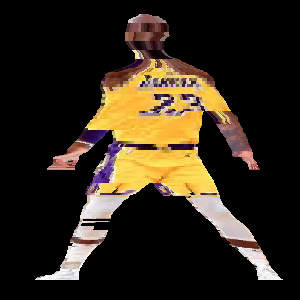

In [31]:
def findLeftAndRight(contourPoints, targetPoint):
  w, h = targetPoint
  left = -1
  right = inWidth

  for point in contourPoints:
    if abs(point[1] - h) < 3:

      if point[0] < w and point[0] > left:
        left = point[0]

      if point[0] > w and point[0] < right:
        right = point[0]

  if left == -1:
    left = w
  if right == inWidth:
    right = w

  return left, right

def getInterPolatePoints(pointStart, pointEnd):
  wStart, hStart = pointStart
  wEnd, hEnd = pointEnd

  points = []

  if abs(wStart - wEnd) > abs(hStart - hEnd):
    step =  1 if wStart < wEnd else -1

    for w in range(wStart, wEnd, step):
      k = (w - wStart) / (wEnd - wStart)
      h = int(hStart + k * (hEnd - hStart))
      points.append((w, h))
  else:
    step =  1 if hStart < hEnd else -1

    for h in range(hStart, hEnd, step):
      k = (h - hStart) / (hEnd - hStart)
      w = int(wStart + k * (wEnd - wStart))
      points.append((w, h))

  return points

workImage = np.zeros((inWidth, inHeight, 3), dtype = np.uint8)
inputImage = cv2.imread("./drive/MyDrive/PoseProject/lbj.png")
inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))


for i in range(len(inputPoseLines)):
  print(i)
  # if i != 0:
  #   continue

  inputLine = inputPoseLines[i]
  refLine = refPoseLines[i]
  pointStart1, pointEnd1 = inputLine
  pointStart2, pointEnd2 = refLine

  wStartInput, hStartInput = pointStart1
  wEndInput, hEndInput = pointEnd1
  wStartRef, hStartRef = pointStart2
  wEndRef, hEndRef = pointEnd2

  pointsInterpolateRef = getInterPolatePoints(pointStart2, pointEnd2)

  for point in pointsInterpolateRef:
    wRef, hRef = point
    wLeftRef, wRightRef = findLeftAndRight(refContourPoints, (wRef, hRef))
    
    if hEndRef == hStartRef and wStartRef == wEndRef:
      continue

    if wStartRef == wEndRef: 
      kRef = (hRef - hStartInput) / (hEndRef - hStartRef)
    else:
      kRef = (wRef - wStartRef) / (wEndRef - wStartRef)

    for ww in range(wLeftRef, wRightRef):
      wInput = wStartInput + int(kRef * (wEndInput - wStartInput))
      hInput = hStartInput + int(kRef * (hEndInput - hStartInput))
      wLeftInput, wRightInput = findLeftAndRight(inputContourPoints, (wInput, hInput))

      kInput = (ww - wLeftRef) / (wRightRef - wLeftRef)
      wThing = int(wLeftInput * (1 - kInput) + wRightInput * kInput)

      workImage[hRef, ww] = inputImageResize[hInput, wThing]

cv2_imshow(workImage)



  

